# Setup

In [47]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/home_detection/code


In [2]:
from mobilkit.umni import *
from setup import P, Region, Dataset

In [3]:
import shutil

In [4]:
SP.start()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/28 19:19:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load data

In [5]:
algos = ['A0', 'A1', 'A2', 'A3', 'A4']
algo_markers = ['.', 'v', '^', '*', 'd']
# algo_colors = ['#1091a5', '#4835b0', '#ef8507', '#d91d61', '#10ae01']
algo_colors = ['#10ae01', '#047cbd', '#4930c7', '#ff7e81', '#c92ad5']
sns.color_palette(algo_colors)

[(0.06274509803921569, 0.6823529411764706, 0.00392156862745098),
 (0.01568627450980392, 0.48627450980392156, 0.7411764705882353),
 (0.28627450980392155, 0.18823529411764706, 0.7803921568627451),
 (1.0, 0.49411764705882355, 0.5058823529411764),
 (0.788235294117647, 0.16470588235294117, 0.8352941176470589)]

## Datasets and regions

In [6]:
regions = [Region.load(k) for k in P.params.get('regions').keys()]
br = regions[1]; br

Region(Baton Rouge)

In [7]:
datasets = [Dataset.load(k, [r for r in regions if r.key == v['region']][0])
            for k, v in P.params.get('datasets').items()]
ds2 = datasets[1]; ds2

Dataset D2(Baton Rouge: 2021-08-26 - 2021-09-07)

In [8]:
regions = list({ds.region for ds in datasets})

## Common users across all algos

In [9]:
def get_common_users(ds, algos=algos):
    return Seq(list(reduce(set.intersection, [
        set(pd.read_parquet(ds.data / f'homes/{alg}.parquet')[UID])
        for alg in algos])), name=UID)

In [10]:
for ds in tqdm(datasets):
    ds.common_users = get_common_users(ds)

  0%|          | 0/8 [00:00<?, ?it/s]

## Dataset summary

In [11]:
def table_dataset_summary(datasets=datasets):
    res = []
    for ds in tqdm(datasets):
        acs = gpd.read_file(ds.region.data / 'acs.gpkg')
        users = ds.common_users.reset_index()
        pct_popu = round(len(users) / acs['popu'].sum(), 3)
        df = SP.read_parquet(ds.data / 'counts.parquet')
        df = df.join(SP.pdf2sdf(users), on=UID)
        nPings = df.agg(F.sum('n_pings')).collect()[0][0]
        period = ds.start.strftime('%b %-d') + ' – ' + ds.end.strftime('%b %-d, %Y')
        res.append(dict(name=ds.key, region=ds.region.name,
                        period=period, nDays=len(ds.dates),
                        n_users=len(users) / 1000, pct_popu=pct_popu, 
                        n_pings=nPings / 1e6))
    return Pdf(res)

# %time table_dataset_summary() # t=1:28

# M1: Land use performance metric

## Load the buffers
Clip them within the city limit for comparison

In [12]:
def get_resi_buffers_clipped(rgn, max_buffer=200):
    paths = [f for f in (rgn.data / 'landuse/buffers_within_city_limit')
             .glob('*.parquet') if int(f.stem) <= max_buffer]
    return pd.concat([gpd.read_parquet(f) for f in paths])

# get_resi_buffers_clipped(br)

In [13]:
# t=0:07
pbar = tqdm(regions)
for rgn in pbar:
    pbar.set_description(str(rgn))
    rgn.resi = get_resi_buffers_clipped(rgn)

  0%|          | 0/4 [00:00<?, ?it/s]

## Compute performance

In [14]:
def get_resi_detection_rate(ds, alg, users=None, filt_commons=True,
                            save=True, overwrite=False, pbar=False, time=True):
    outfile = ds.data / f'metrics/{alg}/M1.parquet'
    if outfile.exists() and not overwrite:
        return pd.read_parquet(outfile)
    start_time = dt.datetime.now()
    boundary = gpd.read_file(ds.region.data / 'city_limit.gpkg')
    homes = pd.read_parquet(ds.data / f'homes/{alg}.parquet')
    if filt_commons:
        homes = homes.merge(ds.common_users, on=UID)
    if isinstance(users, Pdf):
        homes = homes.merge(users, on=UID)
    homes = mk.geo.pdf2gdf(homes, crs=CRS_DEG)
    homes = (homes.sjoin(boundary, predicate='within')
             .set_index(UID)[['geometry']])
    resi = ds.region.resi.set_index('buffer').sort_index()
    df = Pdf(0, columns=resi.index, index=homes.index)
    rows = zip(resi.index, resi.geometry)
    if pbar: rows = tqdm(list(rows))
    for buf, geom in rows:
        geom = Gdf({'geometry': [geom]}, crs=CRS_DEG)
        within = homes.sjoin(geom, predicate='within')
        df.loc[within.index, buf:] = 1
        homes = homes.loc[list(set(homes.index) - set(within.index))]
    df = df.astype(np.int8)
    df.columns = df.columns.astype(str)
    if save:
        df.to_parquet(U.mkfile(outfile))
    if time:
        print(f'Runtime for {ds} for {alg}: {dt.datetime.now() - start_time}')
    return df
    
# %time x = get_resi_detection_rate(ds2, 'A1', overwrite=1, save=0); x

In [15]:
%%time
# t=3:39 ({1=>0:09, 2=>0:06, 3=>0:16, 4=>0:36, 5=>0:28, 6=>0:47, 7=>0:18, 8=>0:59})
for ds in tqdm(datasets):
    for alg in algos:
        df = get_resi_detection_rate(ds, alg, overwrite=False)

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 720 ms, sys: 160 ms, total: 880 ms
Wall time: 386 ms


## Plot CDF

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 14.9 s, sys: 6.14 s, total: 21.1 s
Wall time: 12.7 s


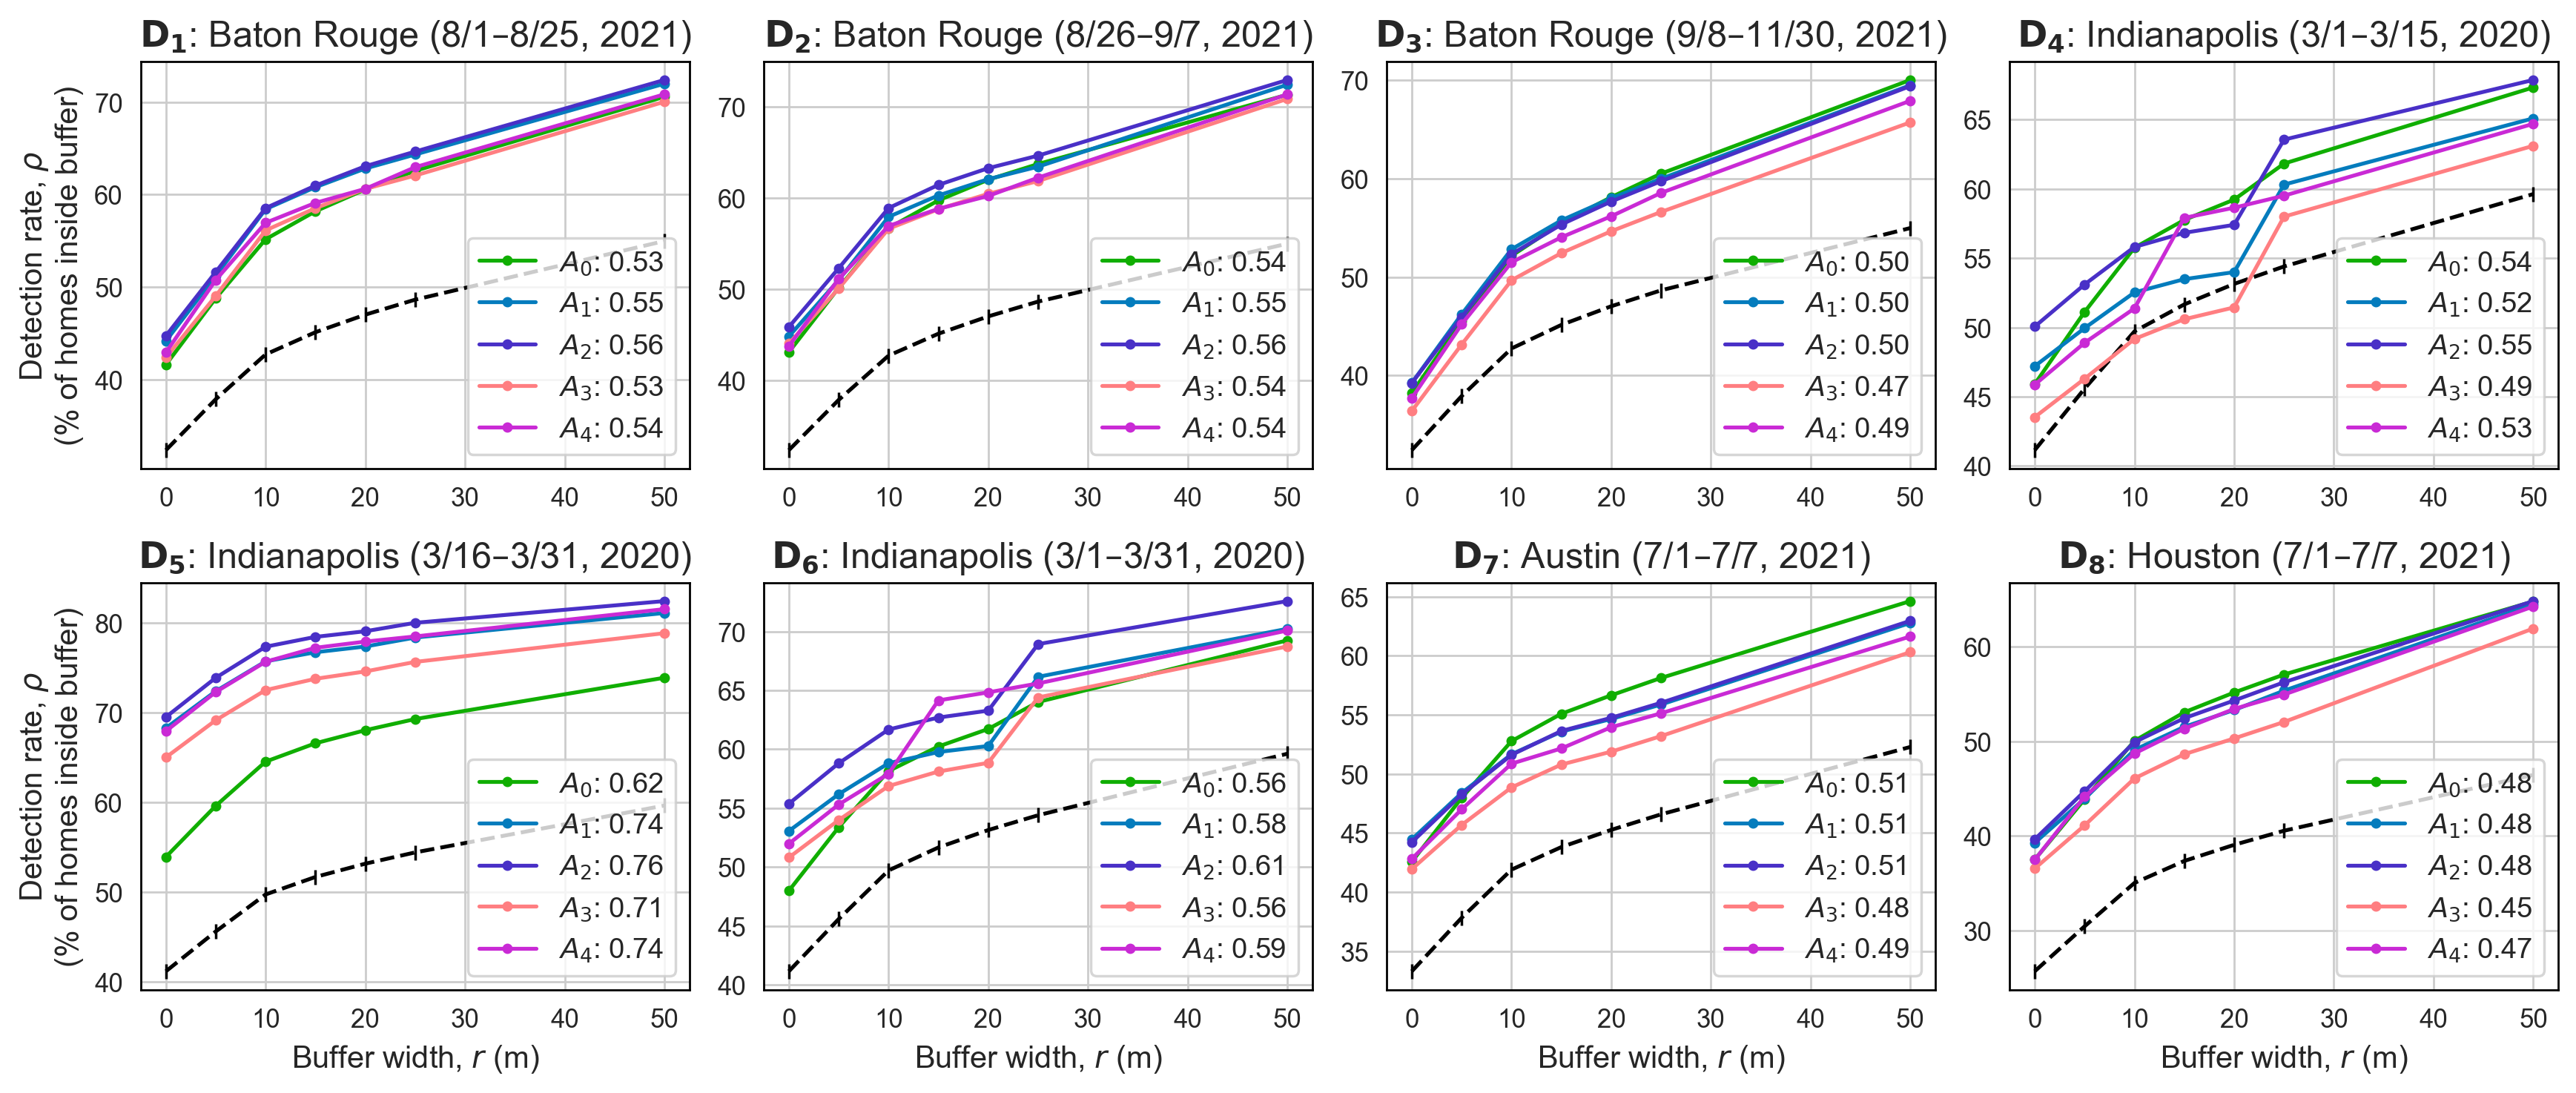

In [16]:
def fig_m1(datasets=datasets, algos=algos, colors=algo_colors, 
           ncol=4, size=(3.5, 3), dpi=100, max_buf=None):
    nrow = int(np.ceil(len(datasets)) / ncol)
    figsize = (ncol * size[0], nrow * size[1])
    _, axes = plt.subplots(nrow, ncol, figsize=figsize, dpi=dpi, sharey=False)
    for i, (ax, ds) in enumerate(tqdm(list(zip(axes.flatten(), datasets)))):
        city_lim = gpd.read_file(ds.region.data / 'city_limit.gpkg')
        tot_area = city_lim.to_crs(CRS_M).area.sum()
        resi = (ds.region.resi.query(f'buffer <= {max_buf}')
                .set_index('buffer').sort_index().to_crs(CRS_M))
        resi['pct_area'] = resi.area / tot_area * 100
        ax = U.plot(ax, framebordercolor='k')
        ax.plot(resi.index, resi['pct_area'], marker='|', color='k', ls='--', lw=1.5)
        for alg, color in zip(algos, algo_colors):
            df = pd.read_parquet(ds.data / f'metrics/{alg}/M1.parquet')
            y = df.sum(axis=0) / len(df)
            y.index = y.index.astype(int)
            y = y[y.index <= max_buf]
            x = y.index.values
            m1 = (y * (x.max() - x)).sum() / (x.max() - x).sum()
            label = '$%s$: %0.2f' % (f'{alg[0]}_{alg[1]}', m1)
            ax.plot(x, y*100, marker='.', color=color, label=label, lw=1.5)
        title = '$\mathbf{%s}$: %s (%s–%s)' % (
            f'{ds.key[0]}_{ds.key[1]}', ds.region.name, 
            ds.start.strftime('%-m/%-d'), ds.end.strftime('%-m/%-d, %Y'))
        xlab = r'Buffer width, $r$ (m)' if i // ncol == nrow - 1 else ''
        ylab = (r'Detection rate, $\rho$'+'\n(% of homes inside buffer)'
                if i % ncol == 0 else '')
        ax = U.plot(ax, title=title, xlab=xlab, ylab=ylab)
        ax.legend(loc='lower right')
    plt.tight_layout()
    
%time x = fig_m1(dpi=250, max_buf=50); x # t=0:18

# M2: Trajectory proximity

## Compute daily min distances

In [17]:
def dist_deg2m(dist, lat, a=6_371_001, b=6_356_752):
    """
    See `mobilkit.geo.dist_m2deg` for more details.
    """
    lat = np.deg2rad(lat)
    curve_radius = (a * b) ** 2 / (
            (a * np.cos(lat)) ** 2 + (b * np.sin(lat)) ** 2) ** 1.5
    return float(np.deg2rad(dist) * curve_radius)

In [18]:
def get_traj_proximity(ds, alg, save=True, overwrite=False):
    outfile = ds.data / f'metrics/{alg}/M2.parquet'
    if outfile.exists() and not overwrite:
        return SP.read_parquet(outfile)
    start_time = dt.datetime.now()
    homes = (pd.read_parquet(ds.data / f'homes/{alg}.parquet')
             .merge(ds.common_users, on=UID)
             .rename(columns={LON: 'homeX', LAT: 'homeY'}))
    df = SP.read_parquet(ds.data / f'night_pings')
    df = df.select(UID, F.arrays_zip(LON, LAT, TS).alias('pts'))
    df = df.select(UID, F.explode('pts').alias('pt'))
    df = df.select(UID, *[F.col('pt')[x].alias(x) for x in [LON, LAT, TS]])
    df = df.withColumn('day', F.floor(F.col(TS) / 86400).cast(T.int16))
    df = df.groupby(UID, 'day').agg(*[
        F.collect_list(x).alias(x) for x in [LON, LAT]])
    df = df.join(SP.pdf2sdf(homes), on=UID)
    df = df.withColumn('n_pings', F.size(LON).cast(T.int16))
    def dist4home(x, y, homex, homey):
        d = np.min(((Arr(x) - homex)**2 + (Arr(y) - homey)**2)**0.5)
        return dist_deg2m(d, homey)
    df = df.withColumn('dist', F.udf(dist4home, T.float)
                       (LON, LAT, 'homeX', 'homeY'))
    df = df.select(UID, 'day', 'n_pings', 'dist')
    if save:
        df.toPandas().to_parquet(U.mkfile(outfile))
    return df
    
# %time x = get_traj_proximity(ds2, 'A1', save=0, overwrite=1); x

In [19]:
%%time
# t=11:03 ({1=>1:01, 2=>0:20, 3=>???, 4=>???, 5=>???, 6=>???, 7=>???, 8=>???})
for ds in tqdm(datasets):
    df = get_traj_proximity(ds, alg, overwrite=False)

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 44.6 ms, sys: 17.3 ms, total: 61.8 ms
Wall time: 4.99 s


## Visualize

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 14.6 s, sys: 4.77 s, total: 19.4 s
Wall time: 13.1 s


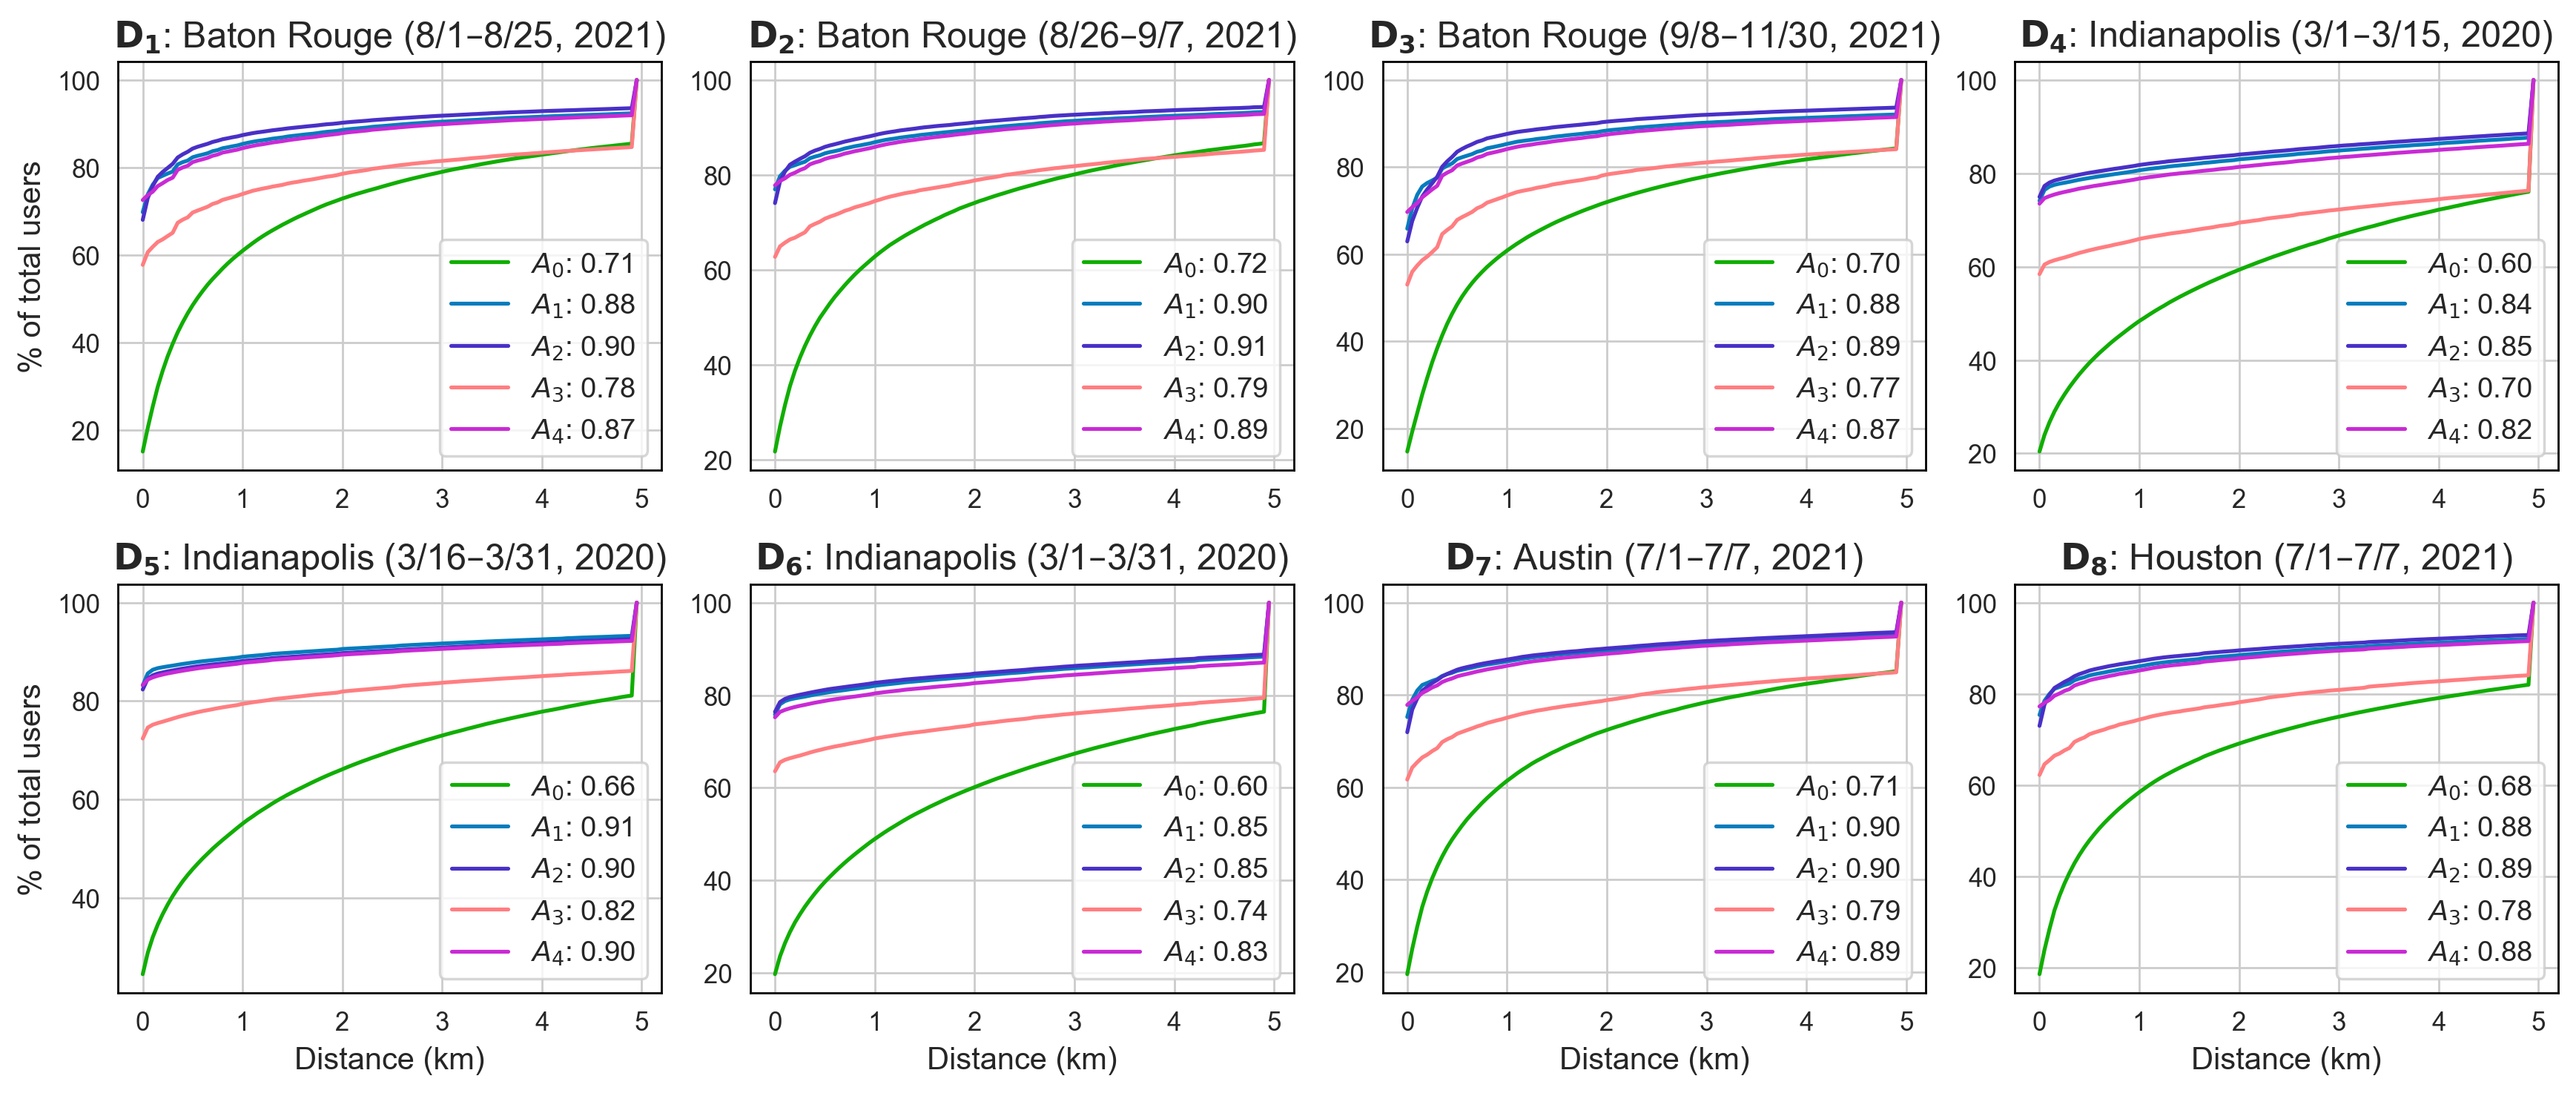

In [20]:
def fig_m2(datasets=datasets, algos=algos, colors=algo_colors, ylog=False,
           ncol=4, vmax=5, bins=100, cum=True, panel_size=(3.5, 3), dpi=120):
    nrow = int(np.ceil(len(datasets)) / ncol)
    figsize = (ncol * panel_size[0], nrow * panel_size[1])
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, dpi=dpi, sharey=False)
    for i, (ax, ds) in enumerate(tqdm(list(zip(axes.flatten(), datasets)))):
        ax = U.plot(ax, framebordercolor='k')
        for alg, color in zip(algos, colors):
            df = pd.read_parquet(ds.data / f'metrics/{alg}/M2.parquet')
            for j, (agg_fn, ls) in enumerate([(np.median, '-')]):
                df2 = df.groupby(UID)['dist'].agg(agg_fn)
                y, x = np.histogram((df2.values / 1000).clip(0, vmax), bins=bins)
                y = (y.cumsum() if cum else y) / y.sum() * 100
                m2 = y.sum() / (100 * len(y))
                label = '$%s$: %0.2f' % (f'{alg[0]}_{alg[1]}', m2)
                ax.plot(x[:-1], y, color=color, ls=ls,
                        label=label if j == 0 else None)
        title = '$\mathbf{%s}$: %s (%s–%s)' % (
            f'{ds.key[0]}_{ds.key[1]}', ds.region.name, 
            ds.start.strftime('%-m/%-d'), ds.end.strftime('%-m/%-d, %Y'))
        xlab = 'Distance (km)' if i // ncol == nrow - 1 else ''
        ylab = '% of total users' if i % ncol == 0 else ''
        ax = U.plot(ax, title=title, xlab=xlab, ylab=ylab, ylog=ylog)
        ax.legend()
    plt.tight_layout()

%time x = fig_m2(dpi=250); x # t=0:13

# M3: Home stay duration

## Load data
Prepared by Shagun and stored in [/home/umni2/a/umnilab/users/mittal53/home inference/data files/final_results](/home/umni2/a/umnilab/users/mittal53/home%20inference/data%20files/final_results).

In [21]:
def copy_m3(datasets=datasets):
    inpath = Path('/home/umni2/a/umnilab/users/mittal53/home inference/data files/final_results')
    for f in inpath.glob('*.parquet'):
        ds_name, alg = f.stem[:2], f.stem[3:5]
        ds = [ds for ds in datasets if ds.key == ds_name][0]
        shutil.copy(f, ds.data / f'metrics/{alg}/M3.parquet')

# %time copy_m3()

## Plot CDF

  0%|          | 0/8 [00:00<?, ?it/s]

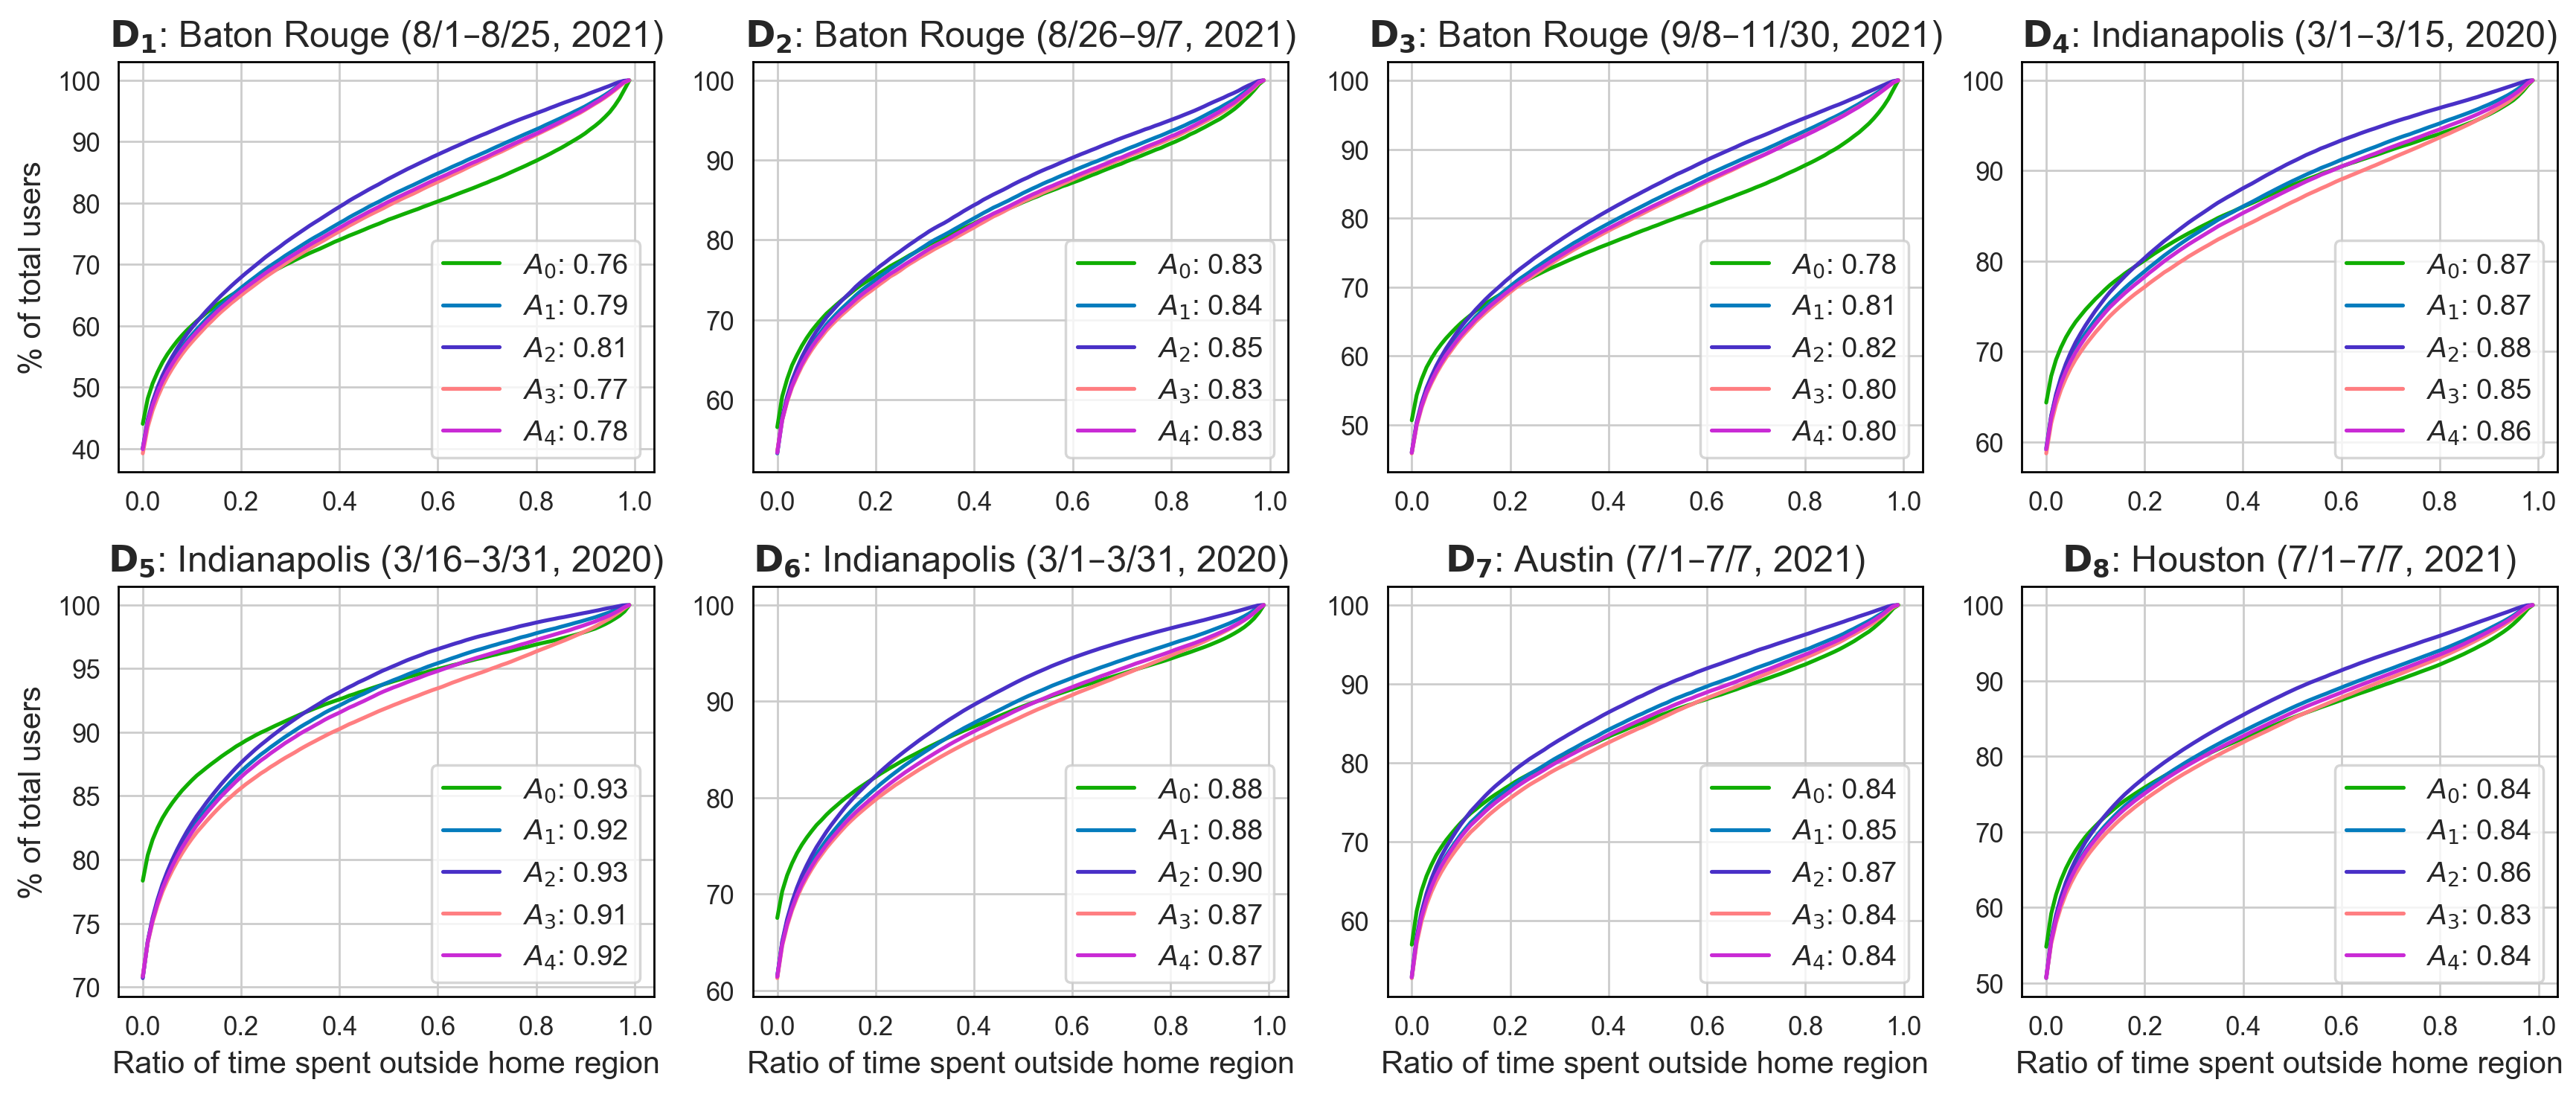

In [22]:
def fig_m3(datasets=datasets, algos=algos, colors=algo_colors, ylog=False,
           ncol=4, bins=100, panel_size=(3.5, 3), dpi=120):
    nrow = int(np.ceil(len(datasets)) / ncol)
    figsize = (ncol * panel_size[0], nrow * panel_size[1])
    _, axes = plt.subplots(nrow, ncol, figsize=figsize, dpi=dpi, sharey=False)
    for i, (ax, ds) in enumerate(tqdm(list(zip(axes.flatten(), datasets)))):
        ax = U.plot(ax, framebordercolor='k')
        for alg, color in zip(algos, colors):
            df = pd.read_parquet(ds.data / f'metrics/{alg}/M3.parquet')
            df = df.merge(ds.common_users, on=UID)
            df['home_stay_ratio'] = 1 - df['home_time_spent'] / df['total_time_spent']
            y, x = np.histogram(df['home_stay_ratio'], bins=bins); x = x[:-1]
            y = y.cumsum() / y.sum()
            # m3 = 2 * y.mean() - 1
            m3 = y.mean()
            label = '$%s$: %0.2f' % (f'{alg[0]}_{alg[1]}', m3)
            ax.plot(x, y * 100, color=color, label=label)
            # ax.plot([0, 1], [0, 100], ls='--', color='k', lw=1)
        title = '$\mathbf{%s}$: %s (%s–%s)' % (
            f'{ds.key[0]}_{ds.key[1]}', ds.region.name, 
            ds.start.strftime('%-m/%-d'), ds.end.strftime('%-m/%-d, %Y'))
        xlab = 'Ratio of time spent outside home region' if i // ncol == nrow - 1 else ''
        ylab = '% of total users' if i % ncol == 0 else ''
        ax = U.plot(ax, title=title, xlab=xlab, ylab=ylab, ylog=ylog)
        ax.legend()
    plt.tight_layout()

fig_m3(dpi=250)

## Overall figure

/tmp/ipykernel_137658/1773435045.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(rticks)
/tmp/ipykernel_137658/1773435045.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(rticks)
/tmp/ipykernel_137658/1773435045.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(rticks)


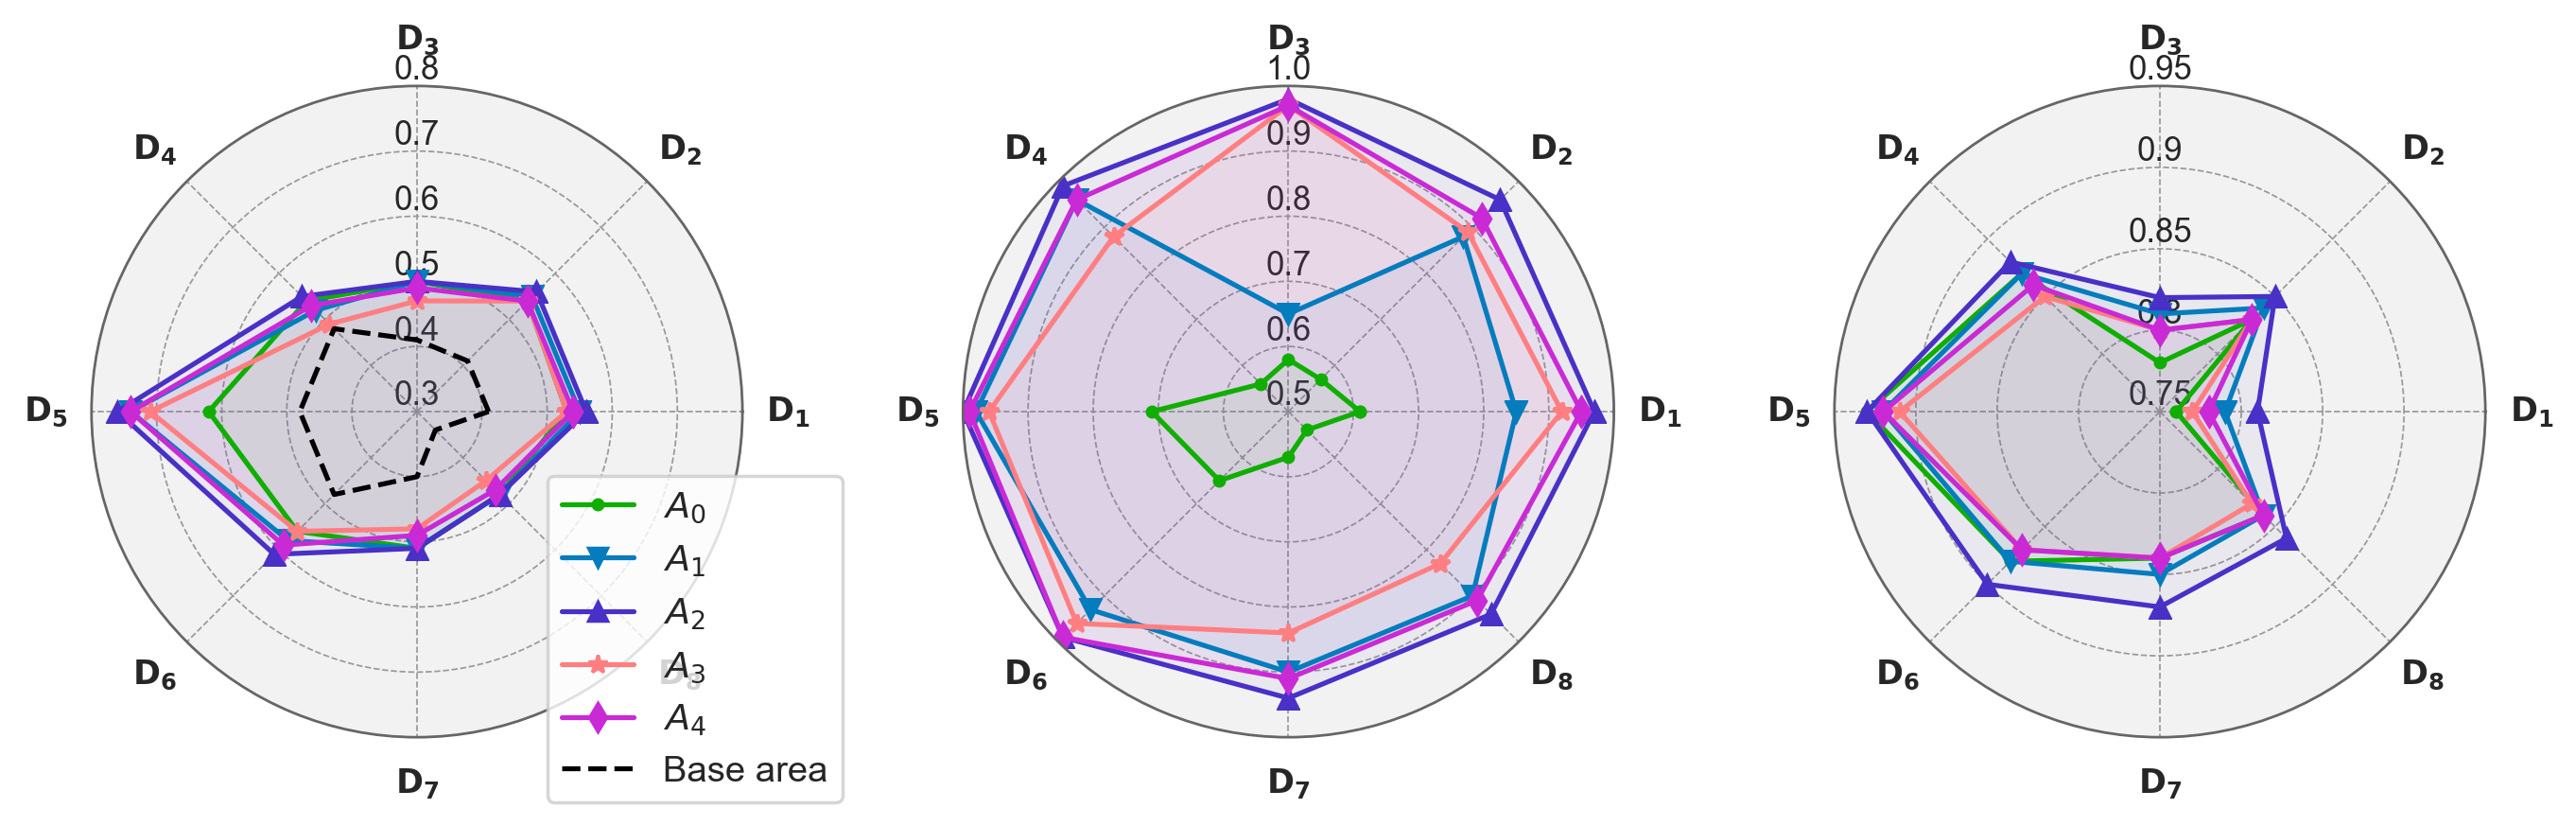

In [23]:
def fig_performance(datasets=datasets, algos=algos, colors=algo_colors, 
                    markers=algo_markers, step=0.1, dpi=100):
    data = pd.read_csv(P.data / '_etc/Paper-Tables.csv')
    _, axes = plt.subplots(1, 3, figsize=(11, 3.5), dpi=dpi, 
                           subplot_kw={'projection': 'polar'})
    sns.set_style('whitegrid')
    for i, (m, df) in enumerate(data.groupby('Metric')):
        df = df.drop(columns='Metric').set_index('Dataset')
        rmin, rmax = df.min().min(), df.max().max()
        x = np.arange(0, 1 + 0.01, step)
        rmin = np.round(x[x <= rmin][-1], 1)
        rmax = np.round(x[x >= rmax][0], 1)
        if m == 'M3':
            rmin, rmax, step = 0.75, 0.95, 0.05
        rticks = np.round(np.arange(rmin, rmax + 0.01, step), 2)
        ax = U.plot(axes[i], ylim=(rmin, rmax))
        ax.set_yticklabels(rticks)
        angles = [n / len(df) * 2 * np.pi for n in range(len(df))]
        angles += angles[:1]
        for alg, color, marker in zip(algos, colors, markers):
            r = df[alg].tolist()
            r += r[:1]
            label = f'${alg[0]}_{alg[1]}$'
            ax.plot(angles, r, color=color, marker=marker, label=label)
            ax.fill(angles, r, color=color, alpha=0.05)
        if m == 'M1':
            r = df['Base area'].tolist()
            r += r[:1]
            ax.plot(angles, r, ls='--', color='k', label='Base area')
            ax.legend(loc=(0.7, -0.1))
        ax.set_xticks(angles[:-1], [
            r'$\mathbf{%s_%s}$' % (ds.key[0], ds.key[1])
            for ds in datasets])
        ax.set_yticks(rticks, rticks, ha='center')
        ax.set_rlabel_position(90)
        ax.grid(ls='--', color='#999', lw=0.5)
        ax.set_facecolor('grey')
        ax.patch.set_alpha(0.1)
        ax.spines['polar'].set_color('#666')
    plt.tight_layout()

fig_performance(dpi=250)

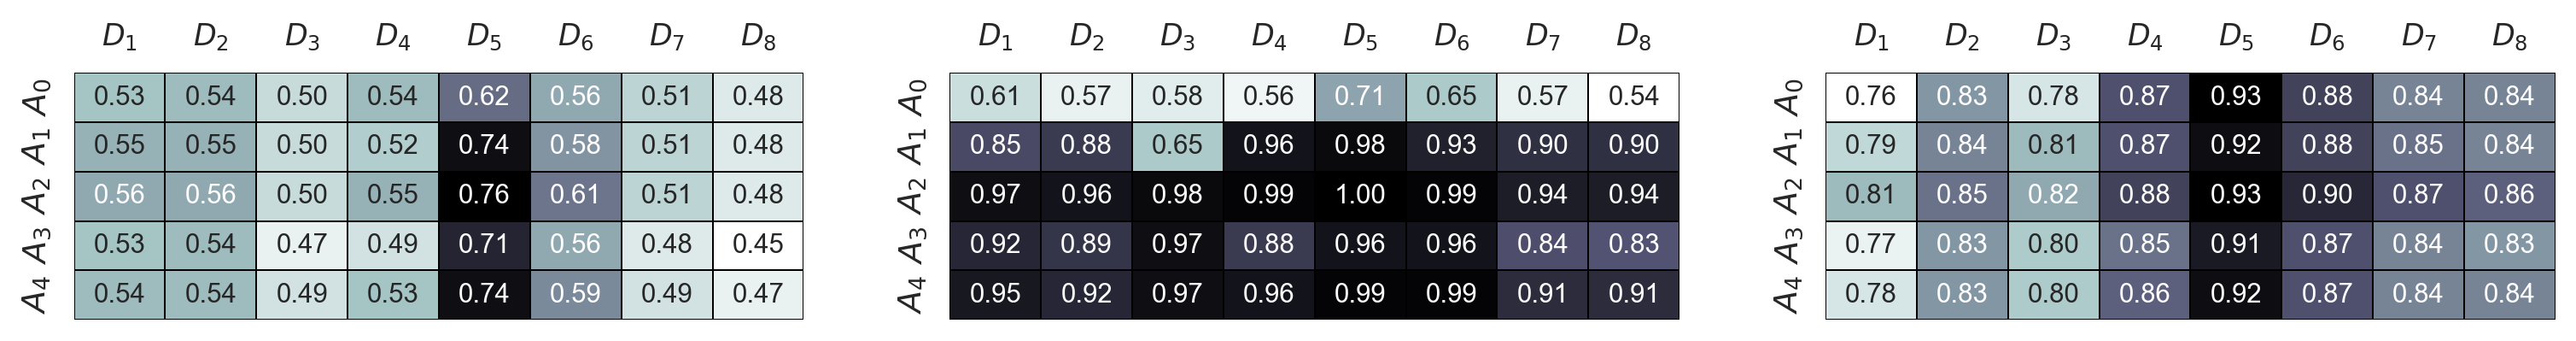

In [24]:
def fig_metrics_table(datasets=datasets, algos=algos, cmap='bone_r', size=(15, 1.5), dpi=250):
    data = pd.read_csv(P.data / '_etc/Paper-Tables.csv').drop(columns='Base area')
    _, axes = plt.subplots(1, 3, figsize=size, dpi=dpi)
    for (metric, df), ax in zip(data.groupby('Metric'), axes):
        df = df.drop(columns='Metric').set_index('Dataset').T
        vmin, vmax = df.min().min(), df.max().max()
        sns.heatmap(data=df, ax=ax, fmt='.2f', cmap=cmap, 
                    annot=True, annot_kws=dict(fontsize=9), cbar=False,
                    norm=plt.Normalize(vmin, vmax), linecolor='k', linewidth=0.1)
        ax.set_yticklabels([f'${x[0]}_{x[1]}$' for x in df.index], fontsize=11)
        ax.set_xticklabels([f'${x[0]}_{x[1]}$' for x in df.columns], fontsize=10)
        ax.tick_params(labelbottom=False,labeltop=True)
        ax.set_xlabel('')

fig_metrics_table()

# Sensitivity analysis

In [25]:
day_hrs = P.params.get('filters.base_day_hours')
slot_size = P.params.get('filters.slot_size')
day_hrs, slot_size

([7, 19], 1800)

## Sorted users by quality

In [26]:
def get_user_ping_count(ds, day_hrs=day_hrs, slot_size=slot_size):
    df = SP.read_parquet(ds.data / 'counts.parquet')
    night_end, night_start = [x * 3600 / slot_size for x in day_hrs]
    df = df.where((df.slot >= night_start) | (df.slot <= night_end))
    df = df.groupby(UID).agg(
        F.count(UID).alias('total_slots'),
        F.sum('n_pings').alias('total_pings'),
        F.countDistinct('day_id').alias('n_nights'))
    df = df.withColumn('avg_pings', F.col('total_pings') / F.col('n_nights'))
    df = df.select(UID, 'total_pings', 'avg_pings', 'total_slots')
    df = df.toPandas()
    return df

# get_user_ping_count(ds2)

In [27]:
%time for ds in tqdm(datasets): ds.counts = get_user_ping_count(ds) # t=0:28

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 303 ms, sys: 293 ms, total: 596 ms
Wall time: 44.5 s


## Get metric sensitivity

In [28]:
def get_user_quality_bin(users, key, bins, is_quantile=False):
    assert UID in users.columns and key in users.columns
    kw = dict(include_lowest=True, right=False)
    if is_quantile:
        df = users.sort_values(key, ascending=False).reset_index(drop=True)
        vmin, vmax = min(bins), max(bins)
        cats = pd.cut(vmin + (vmax - vmin) * (df.index / len(df)), bins, **kw)
        df['binx'] = cats.rename_categories(cats.categories.right)
    else:
        cats = pd.cut(users[key], list(bins) + [np.inf], **kw)
        df = users.assign(binx=cats)
        df['binx'] = cats.cat.rename_categories(cats.cat.categories.left)
    return df.drop(columns=key)

In [29]:
%%time
# t=1:33
def get_metric_sensitivity(metric, bin_key='total_pings', datasets=datasets,
                           algos=algos, bins=np.arange(0, 101, 10), is_quantile=False,
                           hist_bins=100, kwargs=None, save=True, overwrite=False):
    pbar = tqdm(total=len(datasets) * len(algos), desc=f'{metric}: {bin_key}')
    for i, ds in enumerate(datasets):
        all_users = ds.counts[[UID, bin_key]]
        for j, alg in enumerate(algos):
            pbar.update()
            res = []
            pbar.set_description(f'{ds.key} -> {alg}')
            outfile = ds.data / f'sensitivity/{bin_key}/{alg}/{metric}.parquet'
            if outfile.exists() and not overwrite:
                continue
            df = pd.read_parquet(ds.data / f'metrics/{alg}/{metric}.parquet')
            if metric == 'M1':
                df = df.reset_index().melt(UID).astype({'buffer': int})
                df = df[df['buffer'] <= kwargs['max_buffer']]
                df = df.pivot(index=UID, columns='buffer', values='value')
                wt = (df.columns.max() - df.columns).values
                df = df.multiply(wt) / wt.sum()
                df = df.sum(axis=1).rename('yval').reset_index()
            elif metric == 'M2':
                df = (df.groupby(UID).agg({'dist': np.median})['dist']
                      .rename('yval').clip(0, kwargs['max_dist']).reset_index())
            elif metric == 'M3':
                df = df.assign(yval=1 - df['home_time_spent'] / df['total_time_spent'])
                df = df[[UID, 'yval']]
            users = df[[UID]].drop_duplicates().merge(all_users, on=UID)
            users = get_user_quality_bin(users, bin_key, bins, is_quantile=is_quantile)
            df = df.merge(users, on=UID)
            for binx, df2 in df.groupby('binx'):
                if metric == 'M1':
                    yval = df2['yval'].mean()
                elif metric in ['M2', 'M3']:
                    if len(df2) == 0: continue
                    y, _ = np.histogram(df2['yval'], hist_bins)
                    yval = (y.cumsum() / y.sum()).mean()
                res.append(dict(binx=binx, yval=yval))
            res = Pdf(res).dropna()
            if save:
                res.to_parquet(U.mkfile(outfile))

for metric, kw in [('M1', dict(max_buffer=50)), ('M2', dict(max_dist=5000)), ('M3', {})]:
    for key, is_quantile in [('total_pings', True), ('avg_pings', False)]:
        get_metric_sensitivity(metric, key, is_quantile=is_quantile, 
                               kwargs=kw, overwrite=0, save=1)

M1: total_pings:   0%|          | 0/40 [00:00<?, ?it/s]

M1: avg_pings:   0%|          | 0/40 [00:00<?, ?it/s]

M2: total_pings:   0%|          | 0/40 [00:00<?, ?it/s]

M2: avg_pings:   0%|          | 0/40 [00:00<?, ?it/s]

M3: total_pings:   0%|          | 0/40 [00:00<?, ?it/s]

M3: avg_pings:   0%|          | 0/40 [00:00<?, ?it/s]

CPU times: user 357 ms, sys: 48.3 ms, total: 405 ms
Wall time: 357 ms


## Plot

### By total pings

CPU times: user 8.7 s, sys: 825 ms, total: 9.52 s
Wall time: 9.03 s


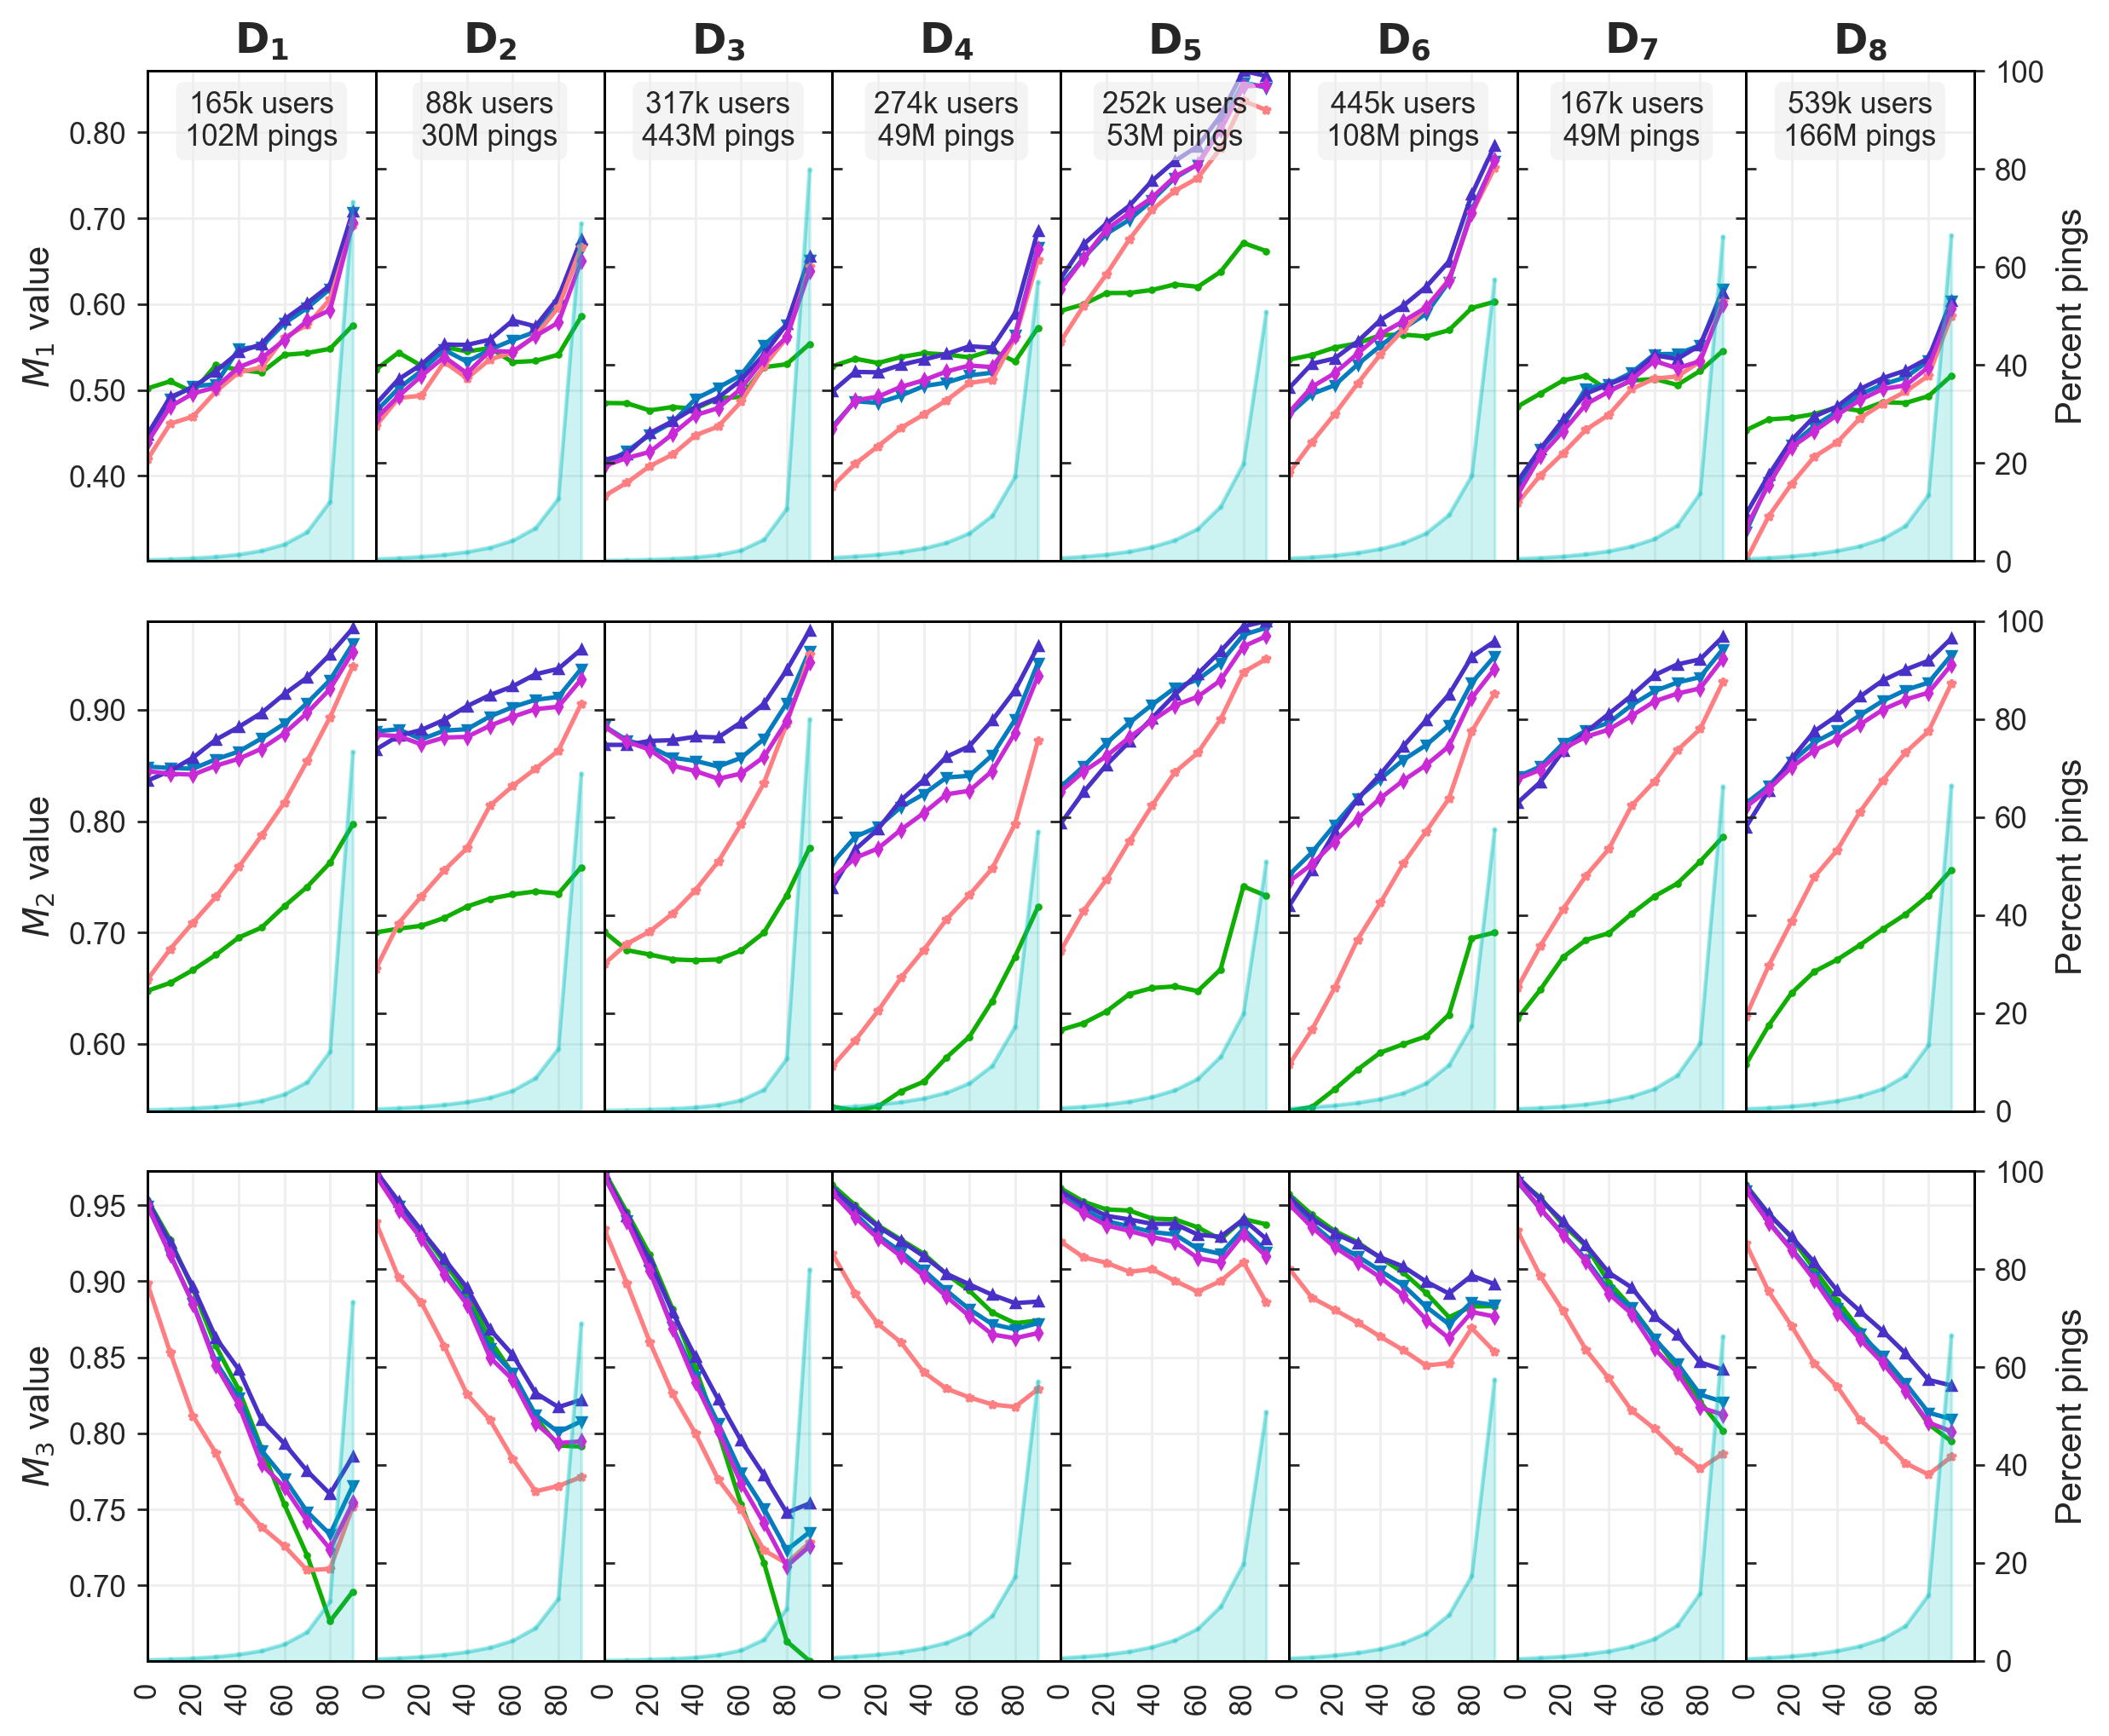

In [30]:
def plot_sensitivity_total(metrics=('M1', 'M2', 'M3'), datasets=datasets,
                           algos=algos, colors=algo_colors, markers=algo_markers,
                           nbin=10, bg_color='c', bg_alpha=0.2,
                           size=(1.25, 2.75), dpi=120):
    nrow, ncol = len(metrics), len(datasets)
    _, axes = plt.subplots(nrow, ncol, dpi=dpi,
                           figsize=(ncol * size[0], nrow * size[1]))
    for i, metric in enumerate(metrics):
        ymin, ymax = [], []
        for j, ds in enumerate(datasets):
            ax = U.plot(axes[i, j], xlim=(0, 100), framebordercolor='k', 
                        xlab='', gridcolor='#eee')
            users = ds.counts.merge(ds.common_users, on=UID)
            nUsers, nPings = len(users), users['total_pings'].sum()
            for (alg, color, marker) in zip(algos, colors, markers):
                root = ds.data / 'sensitivity/total_pings'
                df = pd.read_parquet(f'{root}/{alg}/{metric}.parquet')
                y = df.set_index('binx')['yval'].pipe(lambda x: x[x != 0])
                y.index = (100 - y.index).rename('')
                ymin.append(y.min())
                ymax.append(y.max())
                y.plot(ax=ax, color=color, marker=marker, markersize=3)
            title = r'$\mathbf{%s_%s}$' % (ds.key[0], ds.key[1])
            if i == 0: ax.set_title(title, fontsize=14)
            formatter = mpl.ticker.StrMethodFormatter('{x:,.2f}')
            ax.set_ylabel(f'${metric[0]}_{metric[1]}$ value' if j == 0 else '')
            ax.yaxis.set_major_formatter(formatter)
            if j != 0: ax.set_yticklabels([])
            if i == 0:
                label = f'{nUsers/1e3:.0f}k users\n{nPings/1e6:.0f}M pings'
                ax.text(0.5, 0.96, label, va='top', ha='center', transform=ax.transAxes,
                        bbox=dict(boxstyle='Round', pad=0.3, edgecolor='none',
                                  facecolor='#eee', alpha=0.6))
            y = users.sort_values('total_pings').reset_index(drop=True)
            y['binx'] = pd.cut(range(len(users)), len(df)).codes
            y = y.groupby('binx')['total_pings'].sum()
            y = pd.concat([y, df['binx']], axis=1).set_index('binx')['total_pings']
            y = y / y.sum() * 100
            y.index -= y.index.min()
            twin = U.plot(ax.twinx(), framebordercolor='k', ylim=(0, 100))
            y.plot(ax=twin, color=bg_color, marker='.',
                   markersize=2, lw=1, alpha=bg_alpha)
            y.plot(ax=twin, kind='area', color=bg_color, alpha=bg_alpha)
            twin.set_xticklabels([])
            twin.grid(False)
            twin.set_ylabel('Percent pings' if j == ncol - 1 else '')
            if j != ncol - 1: twin.set_yticklabels([])
            xticks = np.arange(0, 100 + 1, 20)
            ax.set_xticks(xticks[:-1], xticks[:-1], rotation=90)
            if i != nrow - 1: ax.set_xticklabels([])
        ymin, ymax = min(ymin), max(ymax)
        for j, ds in enumerate(datasets):
            axes[i, j].set_ylim(ymin, ymax)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0)
    
%time plot_sensitivity_total(dpi=250)

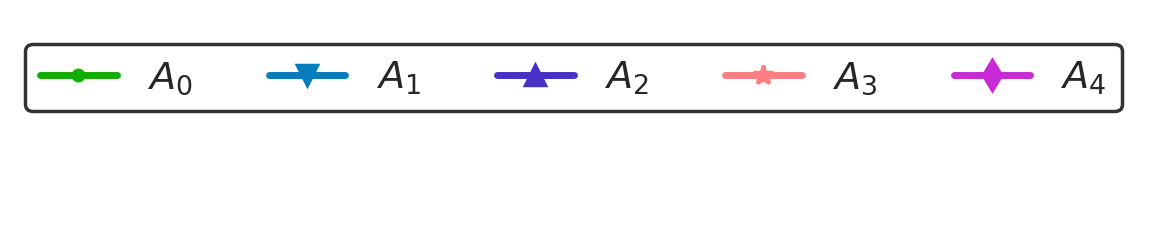

In [34]:
ax = U.plot(size=(1, 1), dpi=250)
ax.legend(handles=[
    mpl.lines.Line2D([0], [0], lw=2, color=color, marker=marker, 
                     label='$%s_%s$' % (alg[0], alg[1]))
    for alg, color, marker in zip(algos, algo_colors, algo_markers)
], ncol=len(algos), edgecolor='k')
ax.axis('off');

### By avg nightly pings

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 7.9 s, sys: 502 ms, total: 8.41 s
Wall time: 7.78 s


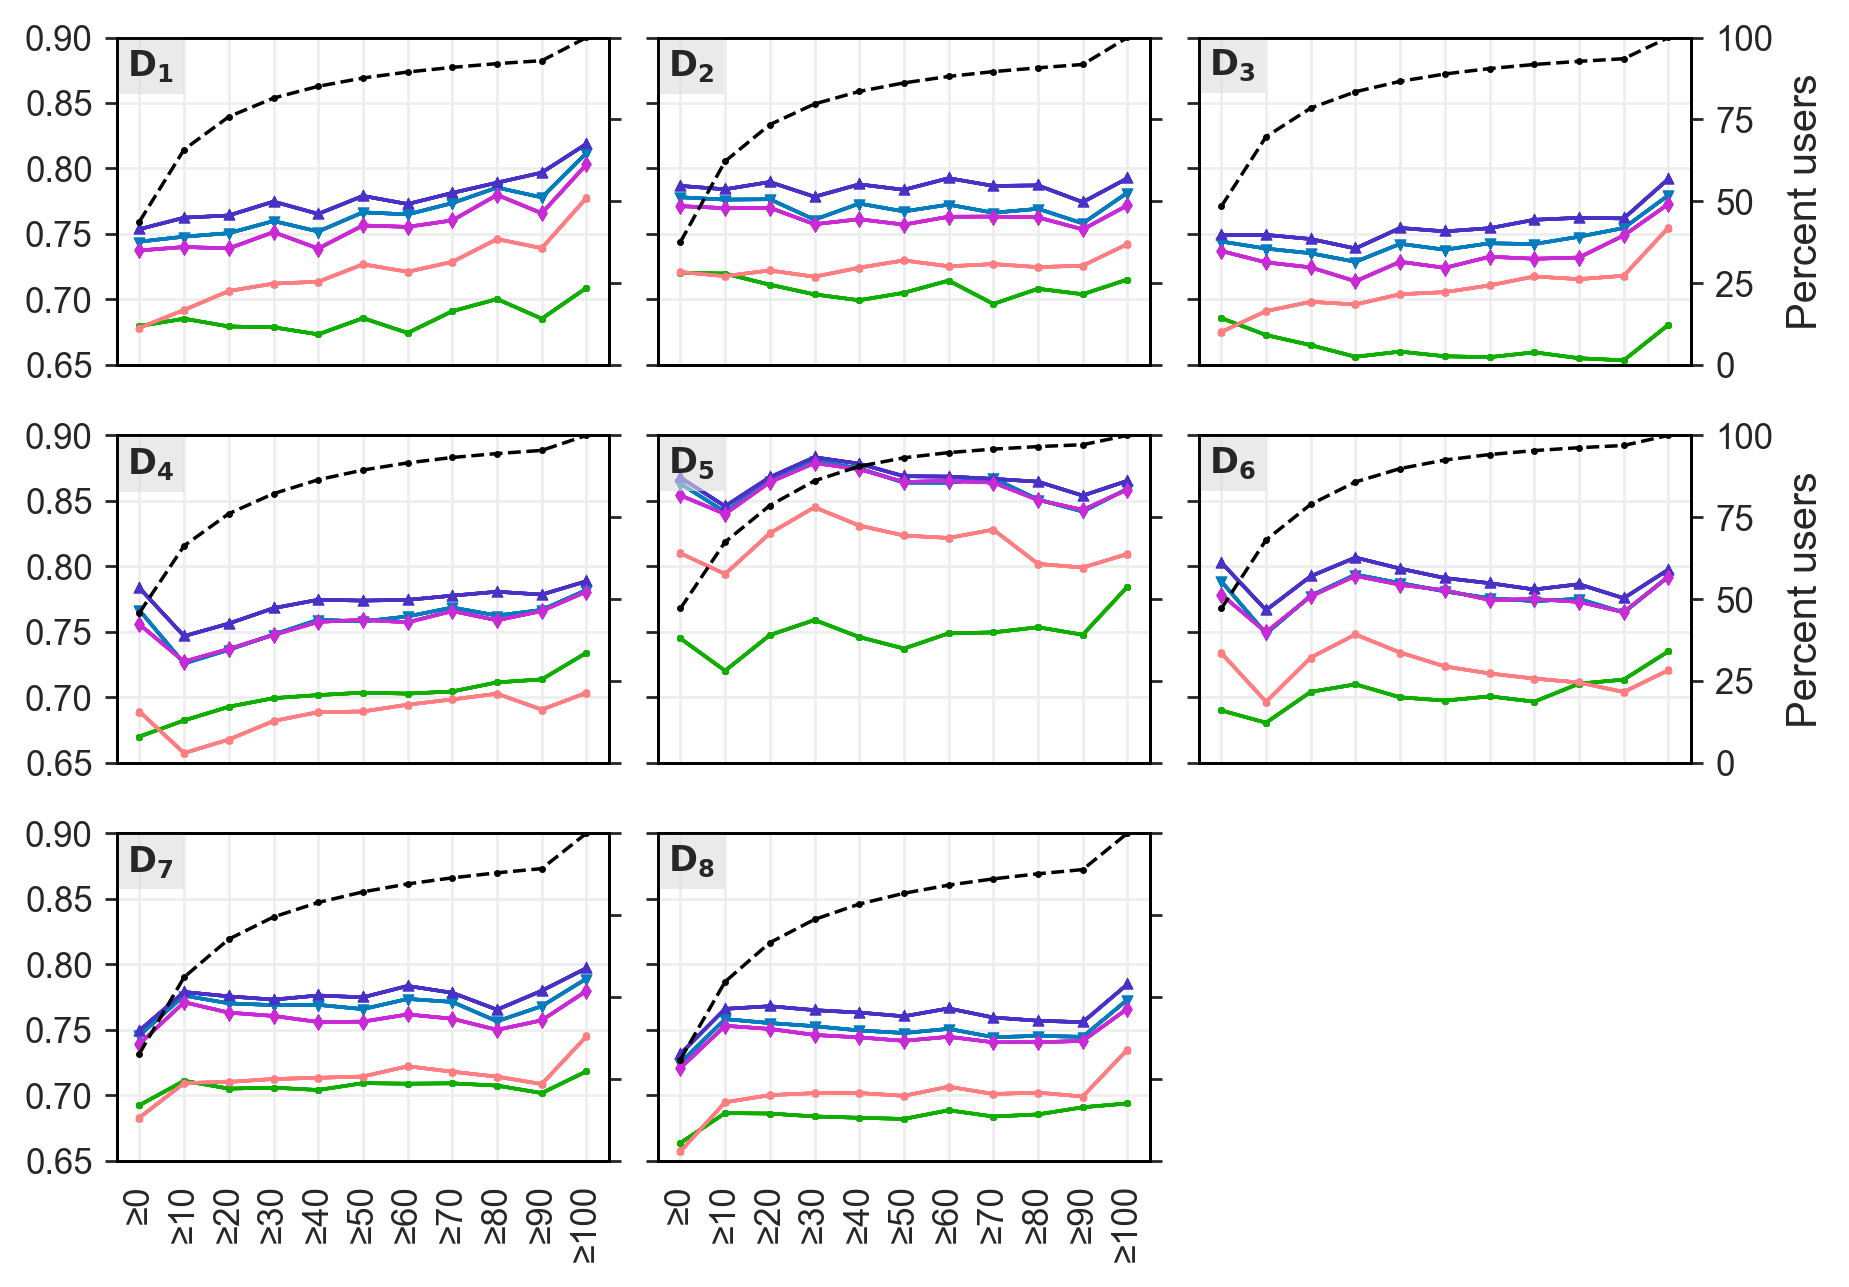

In [46]:
def plot_sensitivity_avg_pings(metrics=('M1', 'M2', 'M3'), datasets=datasets,
                               algos=algos, colors=algo_colors, markers=algo_markers,
                               area_bins=10, bg_color='c', bg_alpha=0.2, ncol=3,
                               size=(2.5, 1.75), dpi=120, cum=True):
    nrow = int(np.ceil(len(datasets) / ncol))
    _, axes = plt.subplots(nrow, ncol, dpi=dpi, sharey=True,
                           figsize=(ncol * size[0], nrow * size[1]))
    ymin, ymax = 1, 0
    for idx, ds in enumerate(tqdm(datasets)):
        i, j = idx // ncol, idx % ncol
        ax = U.plot(axes[i, j], framebordercolor='k', gridcolor='#eee')
        for (alg, color, marker) in zip(algos, colors, markers):
            root = ds.data / 'sensitivity/avg_pings'
            for alg, color, marker in zip(algos, colors, markers):
                df = pd.concat([
                    pd.read_parquet(f'{root}/{alg}/{metric}.parquet')
                    .set_index('binx')['yval'].rename(metric)
                    for metric in metrics], axis=1)
                y = (df['M1'] + df['M2'] + (df['M3'])) / 3
                ymin = min(ymin, y.min())
                ymax = max(ymax, y.max())
                y.plot(ax=ax, color=color, marker=marker, markersize=2, lw=1)
        if j != 0: ax.set_yticklabels([])
        usr = ds.counts.merge(ds.common_users, on=UID)
        title = r'$\mathbf{%s_%s}$' % (ds.key[0], ds.key[1])
        ax.text(0.02, 0.97, title, va='top', ha='left', transform=ax.transAxes,
                bbox=dict(boxstyle='Square', pad=0.3, edgecolor='none',
                          facecolor='#ddd', alpha=0.6))
        bins = y.index.tolist() + [np.inf]
        usr['binx'] = pd.cut(usr['avg_pings'], bins, labels=y.index.tolist(), 
                             include_lowest=True, right=False)
        usr = usr.groupby('binx').size().rename('n_users')
        usr = usr / usr.sum() * 100
        if cum: usr = usr.cumsum()
        twin = ax.twinx()
        twin = U.plot(twin, framebordercolor='k', ylim=(0, 100))
        twin.plot(usr, color='k', marker='.',
                  markersize=2, lw=1, ls='--')
        twin.grid(False)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks(y.index, [f'≥{int(x)}' for x in y.index], rotation=90)
        if i != nrow - 1: ax.set_xticklabels([])
        twin.set_xlabel('')
        twin.set_ylabel('Percent users' if j == ncol - 1 else '')
        if i != nrow - 1: twin.set_xticklabels([])
        if j != ncol - 1: twin.set_yticklabels([])
        if j != 0: ax.set_yticklabels([])
    ymin = np.floor(ymin * 20) / 20
    ymax = np.ceil(ymax * 20) / 20
    yticks = np.round(np.arange(ymin, ymax + 0.04, 0.05), 2)
    for i, ax in enumerate(axes.flatten()):
        ax.set_ylim(ymin, ymax)
        ax.set_yticks(yticks, [f'{x:.2f}' for x in yticks])
        if i >= len(datasets):
            ax.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1)
    
%time plot_sensitivity_avg_pings(dpi=250)

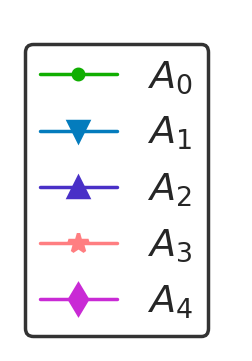

In [33]:
ax = U.plot(size=(1, 1), dpi=250)
handles = [mpl.lines.Line2D([0], [0], lw=1, color=color, marker=marker,
                            label='$%s_%s$' % (alg[0], alg[1]))
           for alg, color, marker in zip(algos, algo_colors, algo_markers)]
ax.legend(handles=handles, edgecolor='k')
ax.axis('off');